# PDE Examples

In [1]:
from collections import defaultdict
import copy
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
default_solver_parameters = {
    'degree': defaultdict(lambda: 1),
    'family': defaultdict(lambda: 'CG'),
    'space' : defaultdict(lambda: fd.FunctionSpace),
    'pdesubsystem': defaultdict(lambda: 1),
    'linear_solver': defaultdict(lambda: 'gmres'),
    'T': 1., # End time for simulation,
    'dt': 0.001  # timestep,
}

def recursive_update(dst, src):
    """Update dict dst with items from src deeply ("deep update")."""
    for key, val in src.items():
        if key in dst and isinstance(val, dict) and isinstance(dst[key], dict):
            dst[key] = recursive_update(dst[key], val)
        else:
            dst[key] = val
    return dst

solver_parameters  = copy.deepcopy(default_solver_parameters)

In [3]:
class PDESystem:
    """
    A base class for solving a system of equations
    """
    def __init__(self, system_composition, mesh, parameters):      # removed problem(mesh)
        self.system_composition = system_composition         # Total system comp.
        self.system_names = []                               # Compounds solved for
        self.names = []                                      # All components
        self.mesh = mesh
        self.prm = parameters
        
        
        self.t0 = 0                                           # Simulation time
        self.tstep = 0                                       # Time step
        self.total_number_iters = 0                          #
        self.num_timesteps = 0                               #
                
        for sub_system in system_composition: 
            system_name = ''.join(sub_system) 
            self.system_names.append(system_name)
            for n in sub_system:       # Run over all individual components
                self.names.append(n)
                
        self.setup_system()
        
    def setup_system(self):
        self.define_function_spaces(self.mesh, self.prm['degree'], # removed self.mesh
                              self.prm['space'], self.prm['family']) # removed cons
        self.setup_subsystems()
        self.pdesubsystems = dict((name, None) for name in self.system_names)
        self.normalize     = dict((name, None) for name in self.system_names)
        self.bc            = dict((name,   []) for name in self.system_names)
        self.setup_form_args()

#         if hasattr(self.problem, 'add_pdesystem'):
#             self.problem.add_pdesystem(self, self.prm['familyname'])

    def define_function_spaces(self, mesh, degree, space, family):
        """Define functionspaces for names and system_names"""
        V = self.V = dict((name, space[name](mesh, family[name], degree[name])) for name in self.names)
        #Add function space for compound functions for the sub systems
#         V.update(dict(
#             (sys_name, 'MixedFunctionSpace')
#             for sub_sys, sys_name in zip(self.system_composition,
#                                          self.system_names) 
#                                          if len(sub_sys) > 1))
    def setup_subsystems(self):
        V, sys_names, sys_comp = \
               self.V, self.system_names, self.system_composition
#         print(V, sys_names, sys_comp)
        q = dict((name, None) for name in sys_names)
        v = dict((name, None) for name in sys_names)
        
        # Create compound functions for the various sub systems
        for sub_sys in sys_comp:
            if len(sub_sys) > 1:
                for name in sub_sys:
                    q.update(dict([(name+'_trl', fd.TrialFunction(V[name]))]))
                    v.update(dict([(name+'_tst', fd.TestFunction(V[name]))]))
                
#         q = dict((name, None) for name in sys_names)
#         v = dict((name, None)  for name in sys_names)
        
#         # Split the various compound functions into sub functions
#         for sub_sys, sys_name in zip(sys_comp, sys_names):
#             print('sub_sys', sub_sys, ' length', len(sub_sys), '\n')
#             print('sys_name', sys_name, '\n')
#             if len(sub_sys) > 1:
#                 for name in sub_sys:
#                     print(name)
#                     q.update(dict(name, fd.TrialFunction(V[name])))
#                     v.update(dict(name, fd.TestFunction(V[name])))

        self.qt, self.vt = q, v
        # Short forms
#         for key, value in v.items(): setattr(self, 'v_' + key, value)
#         for key, value in q.items(): setattr(self, key, value) 

    def setup_form_args(self):
        V, sys_comp = self.V, self.system_composition
        form_args = {}
        for sub_sys in sys_comp:
            if len(sub_sys) > 1:
                for name in sub_sys:
                    form_args.update(dict( [ (name + '_', fd.Function(V[name]) ) ] ) ) # current
                    form_args.update(dict( [ (name + '_n', fd.Function(V[name]) ) ] ) )
        
        
        form_args.update(self.qt)
        form_args.update(self.vt)
            
        self.form_args = form_args
                    
    def solve(self):
        ''' call on the pdesubsystems to solve for their respective variables'''
        for name in self.system_names:
            self.pdesubsystems[name].solve_subsystem() 
            
class Subdict(dict):
    """Dictionary that looks for missing keys in the solver_namespace"""
    def __init__(self, solver_namespace, sub_name, **kwargs):
        dict.__init__(self, **kwargs)
        self.solver_namespace = solver_namespace
        self.sub_name = sub_name
    
    def __missing__(self, key):
        try:
            self[key] = self.solver_namespace['prm'][key][self.sub_name]
        except:
            self[key] = self.solver_namespace['prm'][key]
        return self[key]
    
class Stokes_solver(PDESystem):
    def __init__(self, mesh, parameters):
        PDESystem.__init__(self, [['u', 'p']], mesh, parameters)
        
        
        self.setup_bcs()
        self.define()
        
    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        self.bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow
        
    def define(self):
        self.pdesubsystems['up'] = Stokes(vars(self), ['u', 'p', 'u'], [self.bcu, self.bcp, None], forms_cnt=3)

class PDESubsystembase:
    def __init__(self, solver_namespace, sub_system, bcs, forms_cnt):        
        self.solver_namespace = solver_namespace
        self.vars = sub_system
        self.mesh = solver_namespace['mesh']
        self.prm = solver_namespace['prm']
        self.form_args = solver_namespace['form_args']
        self.bcs = bcs
        self.forms_cnt = forms_cnt
        
        self.setup_base()
        
    def setup_base(self):
        self.get_form(self.form_args)
        self.setup_prob()
        self.setup_solver()
        
    def query_args(self):
        """Extract the form_args that have been supplied by the system.
           Obtain the solution functions that are being solved for in the problems.
           Obtain the old solution functions that will be replaced after solving at each timestep.
        """
        form_args = self.solver_namespace['form_args']
        self.form_args = form_args
        self.soln = []
        self.old_soln = []
        
        for i in range(self.forms_cnt):
            var = self.vars[i]
            self.soln.append(self.form_args[var+'_']) # create a solution function to be solved
            self.old_soln.append(self.form_args[var+'_n'])
            
    def get_form(self, form_args):
        x = range(1, self.forms_cnt+1)
        self.F = dict.fromkeys(x, None)
        self.a = dict.fromkeys(x, None)
        self.L = dict.fromkeys(x, None)
        
        for i in range(1, self.forms_cnt+1):
            self.F[i] = eval('self.form%d(**form_args)'%(i))
            self.a[i], self.L[i] = fd.system(self.F[i])
        
    def setup_prob(self):
        self.problems = [] # create a list
        for i in range(1, self.forms_cnt+1):
            self.problems.append(fd.LinearVariationalProblem(self.a[i], self.L[i], 
                                                         self.form_args[self.vars[i-1]+'_'], bcs=self.bcs[i-1]))
            # solve for the fd.Function
            
    def setup_solver(self):
        self.solvers = [] # create a list
        for i in range(self.forms_cnt):
            self.solvers.append(fd.LinearVariationalSolver(self.problems[i], 
                                                    solver_parameters=
                                                           {'ksp_type': self.prm['linear_solver']['up'],
                                                                       'pc_type': self.prm['precond']['up']}))


class PDESubsystem(PDESubsystembase):
    """Base class for most PDESubSystems"""
    def __init__(self, solver_namespace, sub_system, bcs, forms_cnt):
        PDESubsystembase.__init__(self, solver_namespace, sub_system, bcs, forms_cnt)
        

    def solve_subsystem(self):
        print('entered subsystem',self.solver_namespace['system_names'])
#         print(self.prm)
        t0 = self.solver_namespace['t0']
        dt = self.prm['dt']
        T = self.prm['T']
        
        while t0 < T:
            for i in range(self.forms_cnt):
#                 print('solving problem: ', i)
                self.solvers[i].solve()
            for i in range(self.forms_cnt):
                self.form_args[self.vars[i]+'_n'].assign(self.form_args[self.vars[i]+'_'])
            
            t0 += dt
#             print(t0)
            if( np.abs( t0 - np.round(t0,decimals=0) ) < 1.e-8): 
                print('time = {0:.3f}'.format(t0))

class Stokes(PDESubsystem):
    
    def form1(self, u_trl, u_tst, u_n, p_n, **kwargs):
        n = fd.FacetNormal(self.mesh)
        f = fd.Constant((0.0, 0.0))
        u_mid = 0.5 * (u_n + u_trl)
        nu = fd.Constant(0.001)
        k = fd.Constant(self.prm['dt'])
        
        def sigma(u, p):
            return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))
        
        Form = fd.inner((u_trl - u_n)/k, u_tst) * fd.dx \
        + fd.inner(fd.dot(u_n, fd.nabla_grad(u_mid)), u_tst) * fd.dx \
        + fd.inner(sigma(u_mid, p_n), fd.sym(fd.nabla_grad(u_tst))) * fd.dx \
        + fd.inner(p_n * n, u_tst) * fd.ds \
        - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), u_tst) * fd.ds \
        - fd.inner(f, u_tst) * fd.dx
        return Form
    
    def form2(self, p_trl, p_tst, p_n, u_, **kwargs):
        k = fd.Constant(self.prm['dt'])
        
        Form = fd.inner(fd.nabla_grad(p_trl), fd.nabla_grad(p_tst)) * fd.dx \
        - fd.inner(fd.nabla_grad(p_n), fd.nabla_grad(p_tst)) * fd.dx \
        + (1/k) * fd.inner(fd.div(u_), p_tst) * fd.dx
        
        return Form
    
    def form3(self, u_trl, u_tst, u_, p_n, p_, **kwargs):
        k = fd.Constant(self.prm['dt'])
        
        Form = fd.inner(u_trl, u_tst) * fd.dx \
        - fd.inner(u_, u_tst) * fd.dx \
        + k * fd.inner(fd.nabla_grad(p_ - p_n), u_tst) * fd.dx
        
        return Form

        
solver_parameters  = copy.deepcopy(default_solver_parameters)

solver_parameters = recursive_update(solver_parameters, 
        {
        'space': {'u': fd.VectorFunctionSpace},
        'degree': {'u': 2},
        'linear_solver': {'up': 'gmres'},
        'precond': {'up': 'sor'}}
        )
mesh = fd.Mesh("../meshes/flow_past_cylinder.msh")

solver = Stokes_solver(mesh, solver_parameters)

print('solver_parameters: ', solver_parameters, '\n')
# print('solver.pdesubsystems: ', solver.pdesubsystems['up'].soln)
print('solver.form_args: ', solver.form_args)

# print('solver.pdesubsystems forms ', solver.pdesubsystems['up'].F[1])
print(solver.pdesubsystems['up'].form1)
solver.solve()

solver_parameters:  {'degree': defaultdict(<function <lambda> at 0x7ff6a2848950>, {'u': 2, 'p': 1}), 'family': defaultdict(<function <lambda> at 0x7ff6a2848840>, {'u': 'CG', 'p': 'CG'}), 'space': defaultdict(<function <lambda> at 0x7ff6a28489d8>, {'u': <function VectorFunctionSpace at 0x7ff6a983a950>, 'p': <function FunctionSpace at 0x7ff6a983a8c8>}), 'pdesubsystem': defaultdict(<function <lambda> at 0x7ff6a2848a60>, {}), 'linear_solver': defaultdict(<function <lambda> at 0x7ff6a2848ae8>, {'up': 'gmres'}), 'T': 1.0, 'dt': 0.001, 'precond': {'up': 'sor'}} 

solver.form_args:  {'u_': Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6a2813b70>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 2), 'u_n': Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7ff6a2813b70>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), na

In [4]:
fd.system?

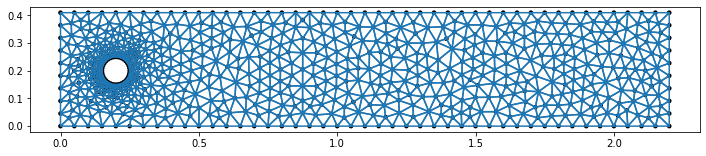

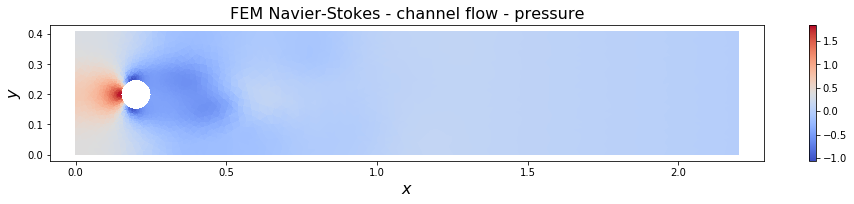

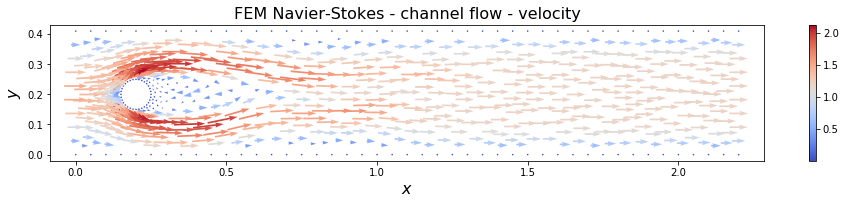

In [5]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.pdesubsystems['up'].form_args['p_'],axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.pdesubsystems['up'].form_args['u_'],axes=ax1)
ax1.axis('equal');

In [6]:
def form(u, u_now, k, v, u_mid, p_now, n, nu, f, **kwargs):
    return fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_mid)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx


SyntaxError: invalid syntax (<ipython-input-6-cc75616fc902>, line 9)

In [7]:
x = [1, 2]
print(x[0])

1


In [8]:
def add_four(a, b, c, d, *kwargs):
    k = a + b + c + d
    return k

x = 1
y = 2
z = 3
w = 4
q = 5

print(add_four(x, y, z, w, q, x, w, 10, 20, 50))

def return_args(*args):
    return len(args)
    
k = return_args(10, 20, 30, 40)
print(k)
print(type(k))

def print_1(a, **kwargs):
    return a

x = {'c_' : 50, 'b' : 30, 'a' : 100}

def get_form(formargs):
#     h = print_a(**formargs)
    h = eval('print_%d(**formargs)' %(1))
    return h

i = get_form(x)
print(x['c'+'_'])

10
4
<class 'int'>
50


In [9]:
y = {'key' : x}
print(y)
print(y['key']['a'])
for args in y:
    print(args)

{'key': {'c_': 50, 'b': 30, 'a': 100}}
100
key


In [10]:
abc = range(10)

alphabet = dict.fromkeys(abc, None)
print(alphabet)
print(len(alphabet))
for i in range(1, 11):
    alphabet[i] = i

print(alphabet)
print(len(alphabet))


{0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None}
10
{0: None, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
11


In [ ]:
abcd = [1, 2, None]
print(len(abcd))